# SHAP and SHAPIQ Comparison Notebook

### I want to compare the shap library and shapiq library outputs, to check they provide the consistent results for some instances. 

1. The first section contains training the model, testing the model and evaluation metrics.
2. The second section contains choosing a data point for explaining from the test split.
3. The visualizations are plotted using both the libraries.
4. Question.

# 1. Data Preprocessing, Model Training, Testing and Evaluation Metrics

In [1]:
# Uncomment the libraries not installed
#!pip install numpy
#!pip install matplotlib
#!pip install pandas
#!pip install scikit-learn
#!pip install xgboost
#!pip install shap
#!pip install shapiq

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
#import joblib
import shap
shap.initjs()

import shapiq
from tqdm.asyncio import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:

drop_list = ['symmetry_worst', 'area_worst', 'symmetry_se','radius_mean','concave points_worst',
            'compactness_se', 'concavity_se','smoothness_se','perimeter_mean','concave points_mean',
            'texture_se','radius_se','smoothness_mean','texture_mean','concave points_se',
            'area_mean','compactness_mean','perimeter_worst','Unnamed: 32', 'id']
#importing our cancer dataset
dataset = pd.read_csv('data.csv')
dataset = dataset.drop(drop_list, axis = 1)
X = dataset.drop(['diagnosis'], axis = 1)
Y = dataset['diagnosis']

In [4]:
#Encoding categorical data values
labelencoder_Y = LabelEncoder()
Y = labelencoder_Y.fit_transform(Y)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [6]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [7]:
classifier = xgb.XGBClassifier()
classifier.fit(X_train_scaled, Y_train)
Y_pred = classifier.predict(X_test_scaled)

In [8]:
print(metrics.classification_report(Y_test, Y_pred))
print(metrics.confusion_matrix(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        90
           1       0.95      0.98      0.96        53

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143

[[87  3]
 [ 1 52]]


In [9]:
# set feature names to classifier
classifier.feature_names = list(X.columns.values)

# 2. Selecting instance from the test dataset to explain 

## (change the instance id in the last row of this code block and run all the blocks below to see the results)

In [10]:
def explain_instance(classifier, X_test, X_test_scaled, Y_test, instance_id):
    """
    Prints and returns the actual values, scaled values, and prediction for a selected instance.
    
    Parameters:
        classifier  : Trained model with feature names
        X_test      : DataFrame of test features (actual values)
        X_test_scaled : Scaled version of X_test (numpy array)
        Y_test      : True labels for the test set
        instance_id : Index of the instance to be explained
        
    Returns:
        dict: Contains actual values, scaled values, true label, and predicted value
    """
    x_explain_actual = X_test.iloc[instance_id]
    x_explain_scaled = X_test_scaled[instance_id]
    y_true = Y_test[instance_id]
    y_pred = classifier.predict(x_explain_scaled.reshape(1, -1))[0]
    
    # Print formatted output
    print(f"\n{'Feature Name':<25}{'Actual Value':<15}{'Scaled Value':<15}")
    print("=" * 50)
    for i, feature in enumerate(classifier.feature_names):
        print(f"{feature:<25}{x_explain_actual[i]:<15}{x_explain_scaled[i]:<15.4f}")

    print("\n" + "=" * 50)
    print(f"Instance ID     : {instance_id}")
    print(f"True Value      : {y_true}")
    print(f"Predicted Value : {y_pred}")
    print("=" * 50)
    
    return {
        "actual_values": x_explain_actual.to_dict(),
        "scaled_values": x_explain_scaled,
        "true_label": y_true,
        "predicted_label": y_pred
    }
explain_this_record = explain_instance(classifier=classifier, X_test=X_test, X_test_scaled=X_test_scaled, Y_test=Y_test, instance_id=0)


Feature Name             Actual Value   Scaled Value   
concavity_mean           0.1445         0.7121         
symmetry_mean            0.2116         1.1253         
fractal_dimension_mean   0.07325        1.5536         
perimeter_se             3.093          0.1224         
area_se                  33.67          -0.1450        
fractal_dimension_se     0.004005       0.1112         
radius_worst             16.41          0.0191         
texture_worst            29.66          0.6640         
smoothness_worst         0.1574         1.0870         
compactness_worst        0.3856         0.8751         
concavity_worst          0.5106         1.2170         
fractal_dimension_worst  0.1109         1.5393         

Instance ID     : 0
True Value      : 1
Predicted Value : 1


## SHAPIQ

### Compute and Visualize the Shapley Interactions for that specific instance

In [11]:
%%capture
# create explanations for different orders
si_order: dict[int, shapiq.InteractionValues] = {}
for order in tqdm([1, 2, len(classifier.feature_names)]):
    index = "k-SII" if order > 1 else "SV"  # will also be set automatically by the explainer
    explainer = shapiq.Explainer(model=classifier, max_order=order, index=index)
    si_order[order] = explainer.explain(x=explain_this_record['scaled_values'])
si_order

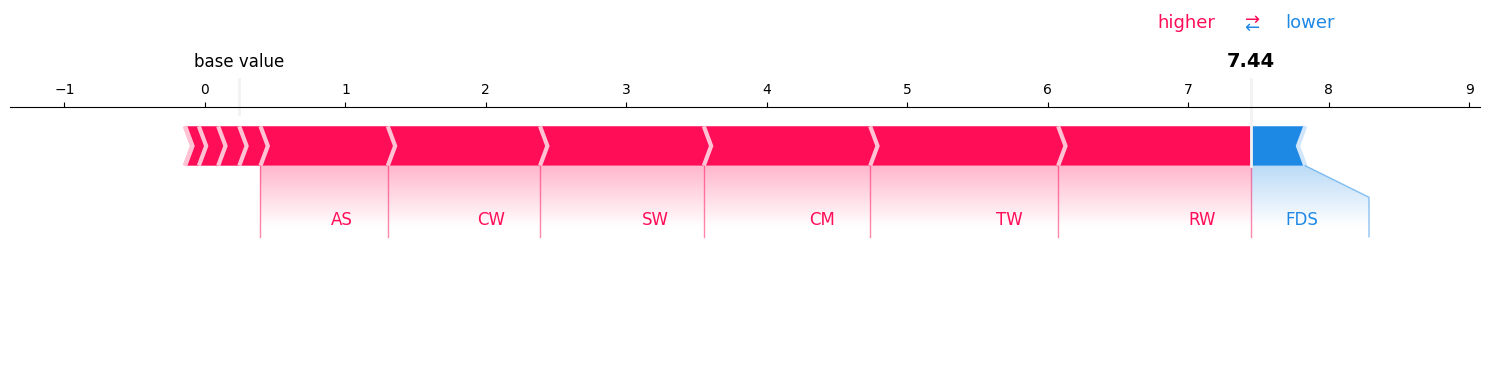

In [12]:
sv = si_order[1]  # get the SV
si = si_order[2]  # get the 2-SII
mi = si_order[len(classifier.feature_names)]  # get the Moebius transform

sv.plot_force(feature_names=classifier.feature_names, show=True)
#si.plot_force(feature_names=classifier.feature_names, show=True)
#mi.plot_force(feature_names=classifier.feature_names, show=True)

## SHAP

### Compute Shapley Values for that specific instance

In [13]:
data_for_prediction_scaled = pd.DataFrame([explain_this_record['scaled_values']], columns=X_test.columns)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(classifier)
#explainer = shap.Explainer(classifier, X_train_scaled)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_scaled)
print("shap values: ", shap_values)
print("base value: ", explainer.expected_value)

shap values:  [[ 1.1844642   0.1501946  -0.07178954 -0.09607071  0.59316266 -0.3014957
   1.4617031   1.1465104   1.3552241   0.12591067  1.3031968   0.3481194 ]]
base value:  -0.6462273


### Visualizing the Model Explanation of the same datapoint using Shap

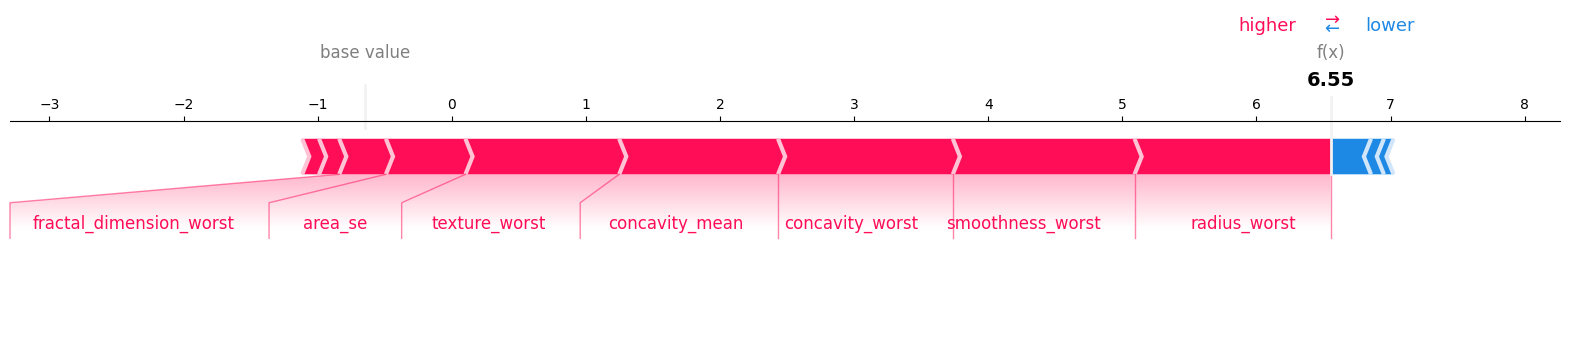

In [14]:
shap.force_plot(explainer.expected_value, shap_values, feature_names=classifier.feature_names, matplotlib=True)

# Comparison of the Numerical Outputs from both the libraries

In [15]:
# Compute SHAP values using both explainers
shap_explainer = shap.TreeExplainer(classifier, X_train_scaled)
shapiq_explainer = shapiq.TreeExplainer(classifier, max_order=1, index="SV")

shap_values = shap_explainer.shap_values(explain_this_record['scaled_values'].reshape(1, -1))
print("shap_values: ", shap_values)
shapiq_values = shapiq_explainer.explain(explain_this_record['scaled_values']).values
print("shapiq_values: ", shapiq_values)

# Add baseline (expected value)
shap_sum = shap_explainer.expected_value + shap_values.sum()
shapiq_sum = shapiq_values.sum()#shapiq_explainer.baseline_value + shapiq_values.sum()

y_predict_proba = classifier.predict_proba(explain_this_record['scaled_values'].reshape(1, -1))[0]

print(f"True Label: {explain_this_record['true_label']}")
print(f"Predicted Label: {explain_this_record['predicted_label']}")
print("predicted probability: ", y_predict_proba)
print("Model output in log-odds:", np.log(y_predict_proba[1] / y_predict_proba[0]))
print("Sum of SHAP values + expected value (SHAP Library):", shap_sum)
print("Sum of SHAP values + baseline (SHAPIQ Library):", shapiq_sum)

shap_values:  [[ 1.14575763  0.16148624 -0.04058166 -0.07827457  0.78053839 -0.21634792
   1.57991888  1.43837674  1.23957111  0.13830555  1.5681721   0.43228585]]
shapiq_values:  [ 1.18446409  0.09737997 -0.38939594  1.37007074  1.33825598  0.00339744
  0.15092493  0.15019461  0.90652817  1.16593348  1.08382003  0.13755617
  0.24535655]
True Label: 1
Predicted Label: 1
predicted probability:  [0.00142395 0.99857605]
Model output in log-odds: 6.552892
Sum of SHAP values + expected value (SHAP Library): 6.552902340042975
Sum of SHAP values + baseline (SHAPIQ Library): 7.4444862226993695


## 4. Question

### I have tested for multiple instances from the dataset, and found out that the sum of shap values and expected_value using SHAP library always equals the model output in the log-odds space, but it's always something different for SHAPIQ library. But according to Shapley value principles their sum should always be equal to the model output. Am I missing something here? I don't know why this is happening. 

### Which materials should I read to find this answer?